# Quick Notes

Author Information:
* JianKai Wang (https://jiankaiwang.no-ip.biz/)
* github: https://github.com/jiankaiwang

# Download Material

## Download Datasets

In [1]:
%cd /tmp
!mkdir voc2012
!ls -al
%cd /tmp/voc2012

/tmp
total 12
drwxrwxrwt 1 root root 4096 Aug 22 14:12 .
drwxr-xr-x 1 root root 4096 Aug 22 14:12 ..
drwxr-xr-x 2 root root 4096 Aug 22 14:12 voc2012
/tmp/voc2012


In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 25.6MB/s 


The following downloading command would cost lots of time.

In [0]:
downloaded = gdrive.CreateFile({'id': "1-2EvfSbKC8xiejD-_kgCkRmn3fI7AzLa"}) 
downloaded.GetContentFile('voc2012.tar')  

In [0]:
!tar -xf voc2012.tar

In [5]:
# 17126
!ls -l VOCdevkit/VOC2012/Annotations/ | wc -l

17126


In [6]:
# 17126
!ls -l VOCdevkit/VOC2012/JPEGImages/ | wc -l

17126


In [7]:
%cd /tmp/voc2012/VOCdevkit/VOC2012/ImageSets/Main
downloaded = gdrive.CreateFile({'id': "1wajMejvrzZjc0sM6M2-khmI1D2bWvAZD"}) 
downloaded.GetContentFile('train_set1.txt')  
downloaded = gdrive.CreateFile({'id': "14wtbRF1qZqkYDPvVzp-qmfL0NwAAbiQ7"}) 
downloaded.GetContentFile('val_set1.txt')  
downloaded = gdrive.CreateFile({'id': "1MzMS9NIC6f6Ev2fXib7WtTzOSds1FxPL"}) 
downloaded.GetContentFile('test_set1.txt')  

/tmp/voc2012/VOCdevkit/VOC2012/ImageSets/Main


## Download Pretrained Weights

In [8]:
%cd /tmp/voc2012

/tmp/voc2012


In [10]:
print("Download yolo weights.")
downloaded = gdrive.CreateFile({'id': "1gzW6wI27dWKLev_8xF9fhapgo40dZmZ6"}) 
downloaded.GetContentFile('yolo_weights.h5')  
print("Download tiny-yolo weights.")
downloaded = gdrive.CreateFile({'id': "1OmBJLF9rQ4xDX8rAQHU1XCzCK4eHuEE6"}) 
downloaded.GetContentFile('tinyyolo_weights.h5')  

Download yolo weights.
Download tiny-yolo weights.


In [0]:
!cp yolo_weights.h5 yolo.h5
!cp yolo_weights.h5 yolo_lastest.h5
!cp tinyyolo_weights.h5 tinyyolo.h5
!cp tinyyolo_weights.h5 tinyyolo_lastest.h5

# Libraries and Environment Settings

Before beginning the tutorial, you have to add VOC2012 dataset into your google drive.
* Download the whole dataset from website http://host.robots.ox.ac.uk/pascal/VOC/voc2012/.
* Add the shared folder owned by others into your google drive.

The following example used Tensorflow 2.0 with Keras API to implement the whole flow consisting training a YOLO or Tiny-YOLO model and making predictions (inference) based on the trained model.

In [0]:
!pip install tensorflow-gpu==2.0.0beta1

In [13]:
import os
import cv2
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.dom.minidom
import pandas as pd

from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, MaxPooling2D, Conv2D, BatchNormalization
#from tensorflow.keras.models import save_model, load_model
from tensorflow.keras import initializers
from tensorflow.keras.layers import LeakyReLU, Lambda, Layer
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.optimizers import Adam, SGD
from skimage.transform import resize
from skimage import io

%matplotlib inline

print("TF version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

TF version: 2.0.0-beta1
Keras version: 2.2.4-tf


In [0]:
#drive.mount('/content/gdrive')

In [0]:
#%cd /content/gdrive/My\ Drive/tmp
#%pwd
#%ls -l

# Hyperparameters

In [16]:
batch_size = 16
lr_init = 1e-4
epochs = 20

# whether to load the pretrained model
# no matter what the inference or the re-train task is ready to do
from_pretrained_model = True
saved_lastest_one = True
from_pretrained_latest_model = False
from_pretrained_latest_model = from_pretrained_model and from_pretrained_latest_model

using_cross_validation = True
cross_validation_counts = 1

use_tiny_yolo = False
if not use_tiny_yolo:
  print("Use yolo v1 model.")
  pretrained_model_path = os.path.join(".", "yolo.h5")
  latest_model_path = os.path.join(".", "yolo_lastest.h5")
  checkpoint_path = os.path.join(".", "temp")
else:
  print("Use tiny yolo model.")
  pretrained_model_path = os.path.join(".", "tinyyolo.h5")
  latest_model_path = os.path.join(".", "tinyyolo_lastest.h5")
  checkpoint_path = os.path.join(".", "temp")  

# ----------------------
# not suggested changing
# ----------------------
lambda_coord = 5.0
lambda_no_obj = 0.5

input_size = (448, 448)
box_num = 2
class_num = 20
divide_size = 7
each_box_pred = box_num * 5 + class_num

# used in both the train and inference stages
gridrange = np.linspace(0., 1., 8)
gridunit = 1.0 / 7.

# 5: (x, y, w, h, confidence)
prediction = divide_size * divide_size * each_box_pred
print("Prediction {} to each data in batch.".format(prediction))

Use yolo v1 model.
Prediction 1470 to each data in batch.


# Data Loading and Preprocessing from Files

## Dataset Labels

In [17]:
labels_to_id = {"person":0, "bird":1, "cat":2, "cow":3, "dog":4, "horse":5, 
               "sheep":6, "aeroplane":7, "bicycle":8, "boat":9, "bus":10, 
               "car":11, "motorbike":12, "train":13, "bottle":14, "chair":15, 
               "diningtable":16, "pottedplant":17, "sofa":18, 
               "tvmonitor":19, "tv":19, "monitor":19}

id_to_labels = {}
for k, v in labels_to_id.items():
  id_to_labels[v] = k
  
print(labels_to_id)
print(id_to_labels)

{'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7, 'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14, 'chair': 15, 'diningtable': 16, 'pottedplant': 17, 'sofa': 18, 'tvmonitor': 19, 'tv': 19, 'monitor': 19}
{0: 'person', 1: 'bird', 2: 'cat', 3: 'cow', 4: 'dog', 5: 'horse', 6: 'sheep', 7: 'aeroplane', 8: 'bicycle', 9: 'boat', 10: 'bus', 11: 'car', 12: 'motorbike', 13: 'train', 14: 'bottle', 15: 'chair', 16: 'diningtable', 17: 'pottedplant', 18: 'sofa', 19: 'monitor'}


## VOC2012 Dataset Generator

In [0]:
class VOC2012_DataGenerator(keras.utils.Sequence):
  """VOC2012 Data Generator for both training and validing.
  
  In this class, we also implement several images argumentation.
  The public API `example_data()` was designed for testing generating the batch images.
  """
  
  def __init__(self, 
               batch_size=32, 
               dim=(448,448), 
               n_channels=3, 
               output_dim=(7, 7, 30), 
               n_classes=20, 
               shuffle=True, 
               list_IDs=None,
               aug=False,
               flip=False,
               source=''):
    self.list_IDs = list_IDs    
    self.dim = dim
    self.batch_size = batch_size
    self.n_channels = n_channels
    self.output_dim = output_dim
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.source = source
    self.aug = aug
    self.flip = flip
    self.on_epoch_end()
    
  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))
  
  def __getitem__(self, index):
    """Generate one batch of data"""

    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    X, y = self.__data_generation(list_IDs_temp)

    return X, y
  
  def on_epoch_end(self):
    """Updates indexes after each epoch"""
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
      
  def __data_generation(self, list_IDs_temp):
    """Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)"""
    # Initialization
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size, *self.output_dim), dtype=float)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      try:
        img_path = "{}/JPEGImages/{}.jpg".format(self.source, ID)
        
        flip_opt = "normal"
        if self.flip:
          flip_opt = np.random.choice(["hor","ver","both","normal"])
          #print("flip...", flip_opt)

        X[i,] = self.__preprocess_image_data(img_path, flip_opt)

        # preprocess the image info
        image_label = self.__process_data_label(ID, flip_opt)
        y[i] = image_label
      except Exception as e:
        tf.print("\nLoad image {} went error. {}\n".format(ID, e))
        continue
      
    return X, y
  
  
  def example_data(self):
    #indexes = self.indexes[:self.batch_size]
    indexes = np.random.choice(self.indexes, self.batch_size, replace=False)
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    X, y = self.__data_generation(list_IDs_temp)
    return X, y
  
  def label_to_id(self, labelName):
    self.labels = {"person":0, "bird":1, "cat":2, "cow":3, "dog":4, "horse":5, 
               "sheep":6, "aeroplane":7, "bicycle":8, "boat":9, "bus":10, 
               "car":11, "motorbike":12, "train":13, "bottle":14, "chair":15, 
               "diningtable":16, "pottedplant":17, "sofa":18, 
               "tvmonitor":19, "tv":19, "monitor":19}
    assert labelName in list(self.labels.keys()), "Label {} not exist.".format(labelName)
    return self.labels[labelName]
  
  def __AdjBrightness(self, image, bright=0):
    # RGB -> HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv = hsv.astype(np.uint16)
    hsv[:,:,2] += bright
    hsv[:,:,2] = np.minimum(hsv[:,:,2], 255)
    hsv[:,:,2] = np.maximum(hsv[:,:,2], 0)
    hsv = hsv.astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  
  def __contrast(self, image, value=3.0):
    # LAB channel 
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Splitting the LAB image to different channels
    l, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=value, tileGridSize=(8,8))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L-channel with the a and b channel
    clab = cv2.merge((cl,a,b))

    return cv2.cvtColor(clab, cv2.COLOR_LAB2BGR)
  
  def __tone(self, image, color_value=0):
    # RGB -> HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv = hsv.astype(np.uint16)
    hsv[:,:,0] += color_value
    hsv[:,:,0] = np.minimum(hsv[:,:,0], 255)
    hsv[:,:,0] = np.maximum(hsv[:,:,0], 0)
    hsv = hsv.astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  
  def __flip(self, img, opt="hor"):
    if opt == "hor":
      return cv2.flip(img, 1)
    elif opt == "ver":
      return cv2.flip(img, 0)
    elif opt == "both":
      return cv2.flip(img, -1)
    else:
      return img
    
  def __flip_coord(self, x1, y1, x2, y2, flip_opt):
    # calculate the coord after flipping
    if flip_opt in ["both", "hor"]:
      # x change
      x1_ = 1.0 - x1
      x2_ = 1.0 - x2
      x1 = x2_
      x2 = x1_

    if flip_opt in ["both", "ver"]:
      # y change
      y1_ = 1.0 - y1
      y2_ = 1.0 - y2
      y1 = y2_
      y2 = y1_    
      
    x1 = np.clip(x1, 1e-8, 9.999e-1)
    y1 = np.clip(y1, 1e-8, 9.999e-1)
    x2 = np.clip(x2, 1e-8, 9.999e-1)
    y2 = np.clip(y2, 1e-8, 9.999e-1)
    return x1, y1, x2, y2
  
  def __preprocess_image_data(self, img_path, flip_opt="normal"):
    #image = io.imread(img_path)
    
    img = cv2.imread(img_path)
    img = img[:,:,::-1]
    
    if self.aug:
      #print("Aug", self.aug)
      brightness = np.random.randint(0,60)
      img = self.__AdjBrightness(img, bright=brightness)

      contrast = np.random.rand()
      img = self.__contrast(img, value=contrast)

      tone = np.random.randint(0,30)
      img = self.__tone(img, tone)
      
    if self.flip:
      img = self.__flip(img, flip_opt)
    
    img = resize(img, (self.dim[0], self.dim[1]))
    img /= 255.0
    
    return img
  
  def __process_data_label(self, ID, flip_opt="normal"):
    """Preprocess the data label."""
    
    label_data = np.zeros((divide_size, divide_size, each_box_pred), np.float)
    anns_file = os.path.join("{}/Annotations/{}.xml".format(self.source, ID))
    
    DomTree = xml.dom.minidom.parse(anns_file)
    annotation = DomTree.documentElement
    filenamelist = annotation.getElementsByTagName('filename')
    filename = filenamelist[0].childNodes[0].data
    objectlist = annotation.getElementsByTagName('object')
    
    cell_boundary = np.linspace(0, 1, divide_size + 1)   
    
    size_info = annotation.getElementsByTagName('size')
    image_width = annotation.getElementsByTagName('width')
    image_height = annotation.getElementsByTagName('height')
    image_width = float(image_width[0].childNodes[0].data)
    image_height = float(image_height[0].childNodes[0].data)
        
    for objects in objectlist:
      
      namelist = objects.getElementsByTagName('name')
      objectname = namelist[0].childNodes[0].data  # category
      
      bndbox = objects.getElementsByTagName('bndbox')
      cropboxes = []
      
      for box in bndbox:
        x1_list = box.getElementsByTagName('xmin')
        x1 = int(x1_list[0].childNodes[0].data)
        y1_list = box.getElementsByTagName('ymin')
        y1 = int(y1_list[0].childNodes[0].data)
        x2_list = box.getElementsByTagName('xmax')
        x2 = int(x2_list[0].childNodes[0].data)
        y2_list = box.getElementsByTagName('ymax')
        y2 = int(y2_list[0].childNodes[0].data)
        w = x2 - x1
        h = y2 - y1

        bx1 = x1 / image_width 
        by1 = y1 / image_height
        bx2 = x2 / image_width
        by2 = y2 / image_height        
        bwidth = w / image_width 
        bheight = h / image_height         
        
        if self.flip:
          # calculate the coord after flipping
          bx1, by1, bx2, by2 = self.__flip_coord(bx1, by1, bx2, by2, flip_opt)
          #print(bx1, by1, bx2, by2)
        
        bxc = bx1 + bwidth / 2.0
        byc = by1 + bheight / 2.0          

        bxc_idx = np.where(bxc >= cell_boundary)[0][-1]         
        byc_idx = np.where(byc >= cell_boundary)[0][-1]     
        label_data[byc_idx, bxc_idx, 0] = bxc
        label_data[byc_idx, bxc_idx, 1] = byc
        label_data[byc_idx, bxc_idx, 2] = bwidth
        label_data[byc_idx, bxc_idx, 3] = bheight
        label_data[byc_idx, bxc_idx, 4] = bxc   
        label_data[byc_idx, bxc_idx, 5] = byc
        label_data[byc_idx, bxc_idx, 6] = bwidth
        label_data[byc_idx, bxc_idx, 7] = bheight
        label_data[byc_idx, bxc_idx, 8] = 1.0   # confidence
        label_data[byc_idx, bxc_idx, 9] = 1.0   # confidence

        used_label = self.label_to_id(objectname)
        label_data[byc_idx, bxc_idx, 10:] = keras.utils.to_categorical(
            used_label, num_classes=self.n_classes)

    return label_data

In [0]:
def getFList(file):
  """Preprocess the VOC annotation files.
  Returns:
    fList: a list conserving the whole image IDs
  """
  fList = []
  with open(file, "r") as fin:
    for line in fin:
      tmp = line.strip().split(' ')
      fList.append(tmp[0])
  return fList

### Split the Datasets

In [20]:
dataDir='/tmp/voc2012/VOCdevkit/VOC2012'
train_file_list = "{}/ImageSets/Main/{}".format(dataDir, "train_set1.txt")
val_file_list = "{}/ImageSets/Main/{}".format(dataDir, "val_set1.txt")
test_file_list = "{}/ImageSets/Main/{}".format(dataDir, "test_set1.txt")

if os.path.exists(train_file_list) and os.path.exists(val_file_list) and os.path.exists(test_file_list):
  print("Use pre-generated splited datasets.")
  train_split = getFList(train_file_list)
  val_split = getFList(val_file_list)
  test_split = getFList(test_file_list)
else:
  print("Generate splited datasets.")
  train_file = "{}/ImageSets/Main/{}".format(dataDir, "train.txt")
  val_file = "{}/ImageSets/Main/{}".format(dataDir, "val.txt")

  train_list = getFList(train_file)
  val_list = getFList(val_file)
  print("Train num: {}, Val num: {}".format(len(train_list), len(val_list)))

  total_list = train_list + val_list
  np.random.shuffle(total_list)

  ratio_list = {"train":0.8, "val":0.1, "test":0.1}
  train_index = int(np.floor(len(total_list) * ratio_list["train"]))
  val_index = train_index + int(np.floor(len(total_list) * ratio_list["val"]))

  train_split = total_list[:train_index]
  val_split = total_list[train_index:val_index]
  test_split = total_list[val_index:]

  with open(train_file_list, "w") as fout:
    for item in train_split:
      fout.write(str(item) + "\n")

  with open(val_file_list, "w") as fout:
    for item in val_split:
      fout.write(str(item) + "\n")

  with open(test_file_list, "w") as fout:
    for item in test_split:
      fout.write(str(item) + "\n")        
    
print("Train split: {}, Val split: {}, Test split: {}".format(
    len(train_split), len(val_split), len(test_split)))  

Use pre-generated splited datasets.
Train split: 9232, Val split: 1154, Test split: 1154


## Data Generator Instance

In [0]:
train_params = {'dim': (448,448),
                'batch_size': batch_size,
                'n_classes': class_num,
                'n_channels': 3,
                'output_dim': (divide_size, divide_size, each_box_pred),
                'list_IDs': train_split,
                'source': os.path.join(dataDir),              
                'aug': True,
                'flip': True,
                'shuffle': True}

valid_params = {'dim': (448,448),
                'batch_size': batch_size,
                'n_classes': class_num,
                'n_channels': 3,
                'output_dim': (divide_size, divide_size, each_box_pred),
                'list_IDs': val_split,
                'source': os.path.join(dataDir),  
                'aug': False,
                'flip': False,
                'shuffle': True}

test_params = {'dim': (448,448),
                'batch_size': batch_size,
                'n_classes': class_num,
                'n_channels': 3,
                'output_dim': (divide_size, divide_size, each_box_pred),
                'list_IDs': test_split,
                'source': os.path.join(dataDir),  
                'aug': False,
                'flip': False,
                'shuffle': True}                

In [0]:
training_generator = VOC2012_DataGenerator(**train_params)
validation_generator = VOC2012_DataGenerator(**valid_params)
test_generator = VOC2012_DataGenerator(**test_params)

In [23]:
eg_data = training_generator.example_data()
eg_data[0].shape, eg_data[1].shape

((16, 448, 448, 3), (16, 7, 7, 30))

row 1, col 4, Category: car
row 3, col 3, Category: dog


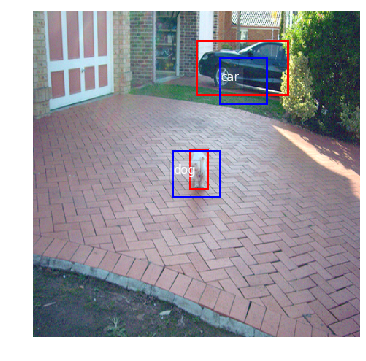

row 6, col 4, Category: sofa


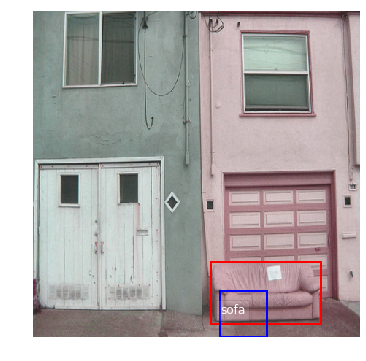

row 3, col 3, Category: train


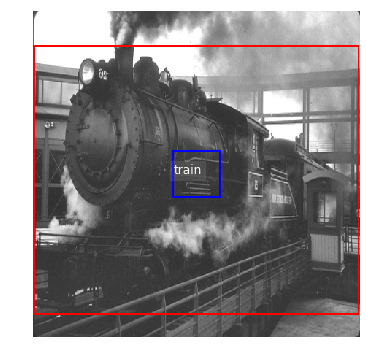

row 3, col 3, Category: dog


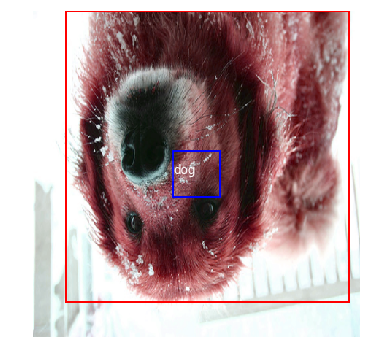

In [24]:
for i in range(4):
  image_data = eg_data[0][i] * 255.0
  image_data.astype(np.int32)
  
  fig, ax = plt.subplots(1, 1, figsize=(6,6))
  ax.imshow(image_data)
  
  box_info = eg_data[1][i]  # (7, 7, 2*5 + class_num)
  
  for row in range(7):
    for col in range(7):
      if box_info[row, col, 8] > 0:
        
        cell_info = box_info[row, col, :]
        category = np.argmax(cell_info[-class_num:] > 0)

        # draw boundary
        cell_xc = cell_info[0] * 448
        cell_yc = cell_info[1] * 448
        cell_width = cell_info[2] * 448
        cell_height = cell_info[3] * 448
        cell_x1 = cell_xc - cell_width / 2.0
        cell_y1 = cell_yc - cell_height / 2.0
        rect = patches.Rectangle(
          (cell_x1, cell_y1),
          cell_width, cell_height,
          linewidth=2,
          edgecolor='r',
          facecolor='none')
        ax.add_patch(rect)

        # draw grid cell
        cell_width = gridunit * 448
        cell_height = gridunit * 448
        cell_y1 = gridrange[row] * 448        
        cell_x1 = gridrange[col] * 448
        cell_xc = cell_x1 + cell_width / 2.0
        cell_yc = cell_y1 + cell_height / 2.0
        rect = patches.Rectangle(
            (cell_x1, cell_y1),
            cell_width, cell_height,
            linewidth=2,
            edgecolor='b',
            facecolor='none')
        ax.add_patch(rect)        

        # label name
        category_name = id_to_labels[np.argmax(cell_info[-class_num:])]
        plt.text(cell_x1, cell_yc, category_name, 
                 fontdict=dict(fontsize=12, color='w'), \
                 bbox=dict(facecolor='w', alpha=0.1))

        print("row {}, col {}, Category: {}".format(row, col, id_to_labels[category]))
  
  plt.axis('off')
  plt.show()

# Model

In [0]:
class Custom_Reshape(Layer):
  """This Class was designed for reshaping the output dimensions.
  
  The output contant would be [(x,y,w,h)*2, (conf)*2, (20 class probabilities)].
  """
  def __init__(self, target_shape=[7,7,each_box_pred], **kwargs):
    super(Custom_Reshape, self).__init__(**kwargs)
    self.target_shape = target_shape
  
  def compute_output_shape(self, input_shape):
    return (input_shape[0],) + self.input_shape  
  
  def call(self, inputs, **kwargs):
    S = [self.target_shape[0], self.target_shape[1]]
    C = class_num
    B = box_num
    idx1 = S[0] * S[1] * C
    idx2 = idx1 + S[0] * S[1] * B
    
    # class prediction
    cls_probs = tf.reshape(
        inputs[:, :idx1], (tf.shape(inputs)[0],) + tuple([S[0], S[1], C])
    )
    cls_probs = tf.nn.softmax(cls_probs)
    
    # confidence
    confs = tf.reshape(
        inputs[:, idx1:idx2], (tf.shape(inputs)[0],) + tuple([S[0], S[1], B])
    )
    confs = tf.sigmoid(confs)
    
    # boxes
    boxes = tf.reshape(
        inputs[:, idx2:], (tf.shape(inputs)[0],) + tuple([S[0], S[1], B*4])
    )
    boxes = tf.sigmoid(boxes)
    
    outputs = tf.concat([boxes, confs, cls_probs], axis=-1)
    return outputs

## Building a Tiny-Yolo Model

In [0]:
def yolo_tiny(inputs):
  """The function was implmented the Tiny YOLO model."""
  x = Conv2D(filters=16, kernel_size=(3, 3), padding="same", bias_initializer='zeros', 
             name="conv0")(inputs)
  x = BatchNormalization(name="bn0")(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # [-1, 224, 224, 3]
  
  x = Conv2D(filters=32, kernel_size=(3, 3), padding="same", bias_initializer='zeros', 
             name="conv1")(x)
  x = BatchNormalization(name="bn1")(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # [-1, 112, 112, 3]
  
  x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", bias_initializer='zeros', 
             name="conv2")(x)
  x = BatchNormalization(name="bn2")(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # [-1, 56, 56, 3]
  
  x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", bias_initializer='zeros', 
             name="conv3")(x)
  x = BatchNormalization(name="bn3")(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # [-1, 28, 28, 3]  
  
  x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", bias_initializer='zeros', 
             name="conv4")(x)
  x = BatchNormalization(name="bn4")(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # [-1, 14, 14, 3]  
  
  x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", bias_initializer='zeros', 
             name="conv5")(x)
  x = BatchNormalization(name="bn5")(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)  # [-1, 7, 7, 3]    
  
  x = Conv2D(filters=1024, kernel_size=(3, 3), padding="same", bias_initializer='zeros', 
             name="conv6")(x)  
  x = BatchNormalization(name="bn6")(x)
  x = LeakyReLU(alpha=0.1)(x)  # [-1, 7, 7, 3]
  
  x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", bias_initializer='zeros', 
             name="conv7")(x)  
  x = BatchNormalization(name="bn7")(x)
  x = LeakyReLU(alpha=0.1)(x)  # [-1, 7, 7, 3]  
  
  x = Flatten()(x)
  x = Dense(4096, activation='linear', name="fc0")(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = Dense(prediction, activation='linear', name='fc1')(x)
  outputs = Custom_Reshape(target_shape=[7, 7, each_box_pred])(x)
  
  return outputs

## Build a Yolo Model

In [0]:
def yolo_v1():
  """The function was implemented YOLO v1 (+v2) model."""
  model = keras.Sequential()
  model.add(Conv2D(filters=192, kernel_size=(7,7), strides=(2,2), padding='same', 
                   kernel_initializer='glorot_uniform', bias_initializer='zeros', 
                   input_shape=(input_size[0], input_size[1], 3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', 
                   kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D())

  model.add(Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), activation='relu',
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=(2,2), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), activation='relu', 
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1),
                   padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))


  model.add(Flatten())
  model.add(Dense(prediction * 2))
  model.add(BatchNormalization())

  # [Batch, 7, 7, Prediction]
  # Prediction = divide_size * divide_size * (box_num * 5 + class_num) = 7 * 7 * (2 * 5 + 3)
  model.add(Dense(prediction))
  model.add(Custom_Reshape(target_shape=[7, 7, each_box_pred]))

  return model

In [28]:
if use_tiny_yolo:
  print("Used tiny YOLO model.")
  inputs = tf.keras.Input(shape=(448, 448, 3))
  outputs = yolo_tiny(inputs=inputs)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)  # [None, 7, 7, PPC]
else:
  print("Used YOLO v1 model.")
  model = yolo_v1()
  
model.summary()

Used YOLO v1 model.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 192)     28416     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 192)     768       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 192)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 192)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 256)     442624    
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 256)     1024      
_________________________________________________________________
activation_1 (Activation)    (None, 

## Let's try the inference.

In [29]:
val_data = validation_generator.example_data()
val_data[0].shape, val_data[1].shape

((16, 448, 448, 3), (16, 7, 7, 30))

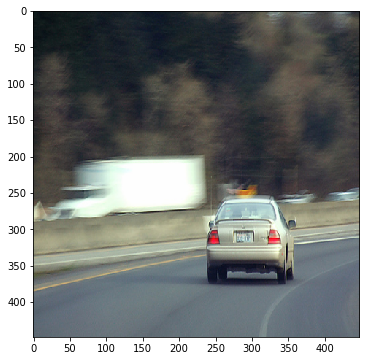

In [30]:
_eg_val_data = np.squeeze(val_data[0][5])
_eg_val_data *= 255.0

fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.imshow(_eg_val_data)
plt.show()

In [31]:
_ef_val_data_res = model.predict(np.expand_dims(_eg_val_data, axis=0))
np.where(_ef_val_data_res[:,:,:,8:10] > 0.7)

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

## Loss Functions

In [0]:
@tf.function
def adjust_coord(center, wh):
  """This function was designed adjusting the coordinates of boxes and their 
  width and height in order to avoid them out of the image.
  """
  _first = center - wh / 2.0  # [N,7,7,1]
  _second = center + wh / 2.0  # [N,7,7,1]
  
  _first_smaller = tf.cast(tf.math.less(_first, 0.0), tf.float32)   # [N,7,7,1]
  _second_larger = tf.cast(tf.math.greater(_second, 1.0), tf.float32)  # [N,7,7,1]
  #tf.print(_first_smaller, _second_larger)
  
  _first_diff = tf.abs(_first)  # [N,7,7,1]
  _second_diff = tf.subtract(_second, 1.0)  # [N,7,7,1]
  #tf.print(_first_diff, _second_diff)
  
  _first_handle = _first_smaller * _first_diff  # [N,7,7,1]
  _second_handle = _second_larger * _second_diff  # [N,7,7,1]
  #tf.print(_first_handle, _second_handle)
  
  _main_diff = tf.maximum(_first_handle, _second_handle)  # [N,7,7,1]
    
  first = center - wh / 2.0 + _main_diff + 1e-8
  second = center + wh / 2.0 - _main_diff + 1e-8
    
  return first, second

In [0]:
def yolov1_loss(y_true, y_pred): 
  """The function was implemented the YOLO v1 loss fucntion."""

  y_true = tf.cast(y_true, tf.float32)  # [N,7,7,PEB], PEB: xywh*2 + conf*2 + class_num
  y_pred = tf.cast(y_pred, tf.float32)  # [N,7,7,PEB], PEB: xywh*2 + conf*2 + class_num
    
  #in_obj = tf.cast(tf.reduce_any(y_true[..., :4] > 0, axis=-1), tf.float32) # [N,7,7]
  in_obj = tf.cast(tf.equal(y_true[..., 8], 1.), tf.float32)  # [N,7,7]
  no_obj = tf.cast(tf.equal(y_true[..., 8], 0.), tf.float32)  # [N,7,7]
  in_obj_exp = tf.expand_dims(in_obj, axis=-1)  # [N,7,7,1]
  no_obj_exp = tf.expand_dims(no_obj, axis=-1)  # [N,7,7,1]
  tf.debugging.assert_rank(in_obj_exp, 4)
  tf.debugging.assert_rank(no_obj_exp, 4)

  truth_xc = tf.expand_dims(y_true[..., 0], axis=-1)  # [N,7,7,1]
  truth_yc = tf.expand_dims(y_true[..., 1], axis=-1)  # [N,7,7,1]
  truth_w = tf.expand_dims(y_true[..., 2], axis=-1)  # [N,7,7,1]
  truth_h = tf.expand_dims(y_true[..., 3], axis=-1)  # [N,7,7,1] 
  truth_x1 = truth_xc - truth_w / 2.0  # [N,7,7,1]
  truth_y1 = truth_yc - truth_h / 2.0  # [N,7,7,1]
  truth_x2 = truth_xc + truth_w / 2.0  # [N,7,7,1]
  truth_y2 = truth_yc + truth_h / 2.0  # [N,7,7,1]
  tf.debugging.assert_rank(truth_y2, 4)
  
  gridrange = tf.linspace(0., 1., 8)
  gridunit = tf.constant(1.0 / 7.)
  grids = tf.meshgrid(gridrange, gridrange)
  grid_cells = tf.stack(grids, axis=-1)  # [8,8,2]
  #grid_cells_tp = tf.transpose(grid_cells, [1,0,2])  # [8,8,2]
  grid_cells_tp = grid_cells  # [8,8,2], [2] : [x(col), y(row)] relative to the top-left position
  grid_cells_units = tf.expand_dims(grid_cells_tp[:7,:7,:], axis=0)  # [1,7,7,2]
  grid_cells_bs = tf.tile(grid_cells_units, [batch_size,1,1,1])  # [N,7,7,2]
  grid_cell_col = grid_cells_bs[..., 0]  # [N,7,7], idx 0 == move in x axis
  grid_cell_col_bs = tf.expand_dims(grid_cell_col, axis=-1)  # [N,7,7,1]  
  grid_cells_row = grid_cells_bs[..., 1]  # [N,7,7], idx 1 == move in y axis
  grid_cells_row_bs = tf.expand_dims(grid_cells_row, axis=-1)  # [N,7,7,1]
  #return grid_cells_bs, grid_cell_col_bs, grid_cells_row_bs

  # tensorflow containers
  xy_dif_pow = []
  wh_dif_pow = []     
  bbox_iou = []
  confidence_list = []
  
  for n in range(box_num):
    n_xc = 0 + 4*n
    n_yc = 1 + 4*n
    n_w = 2 + 4*n
    n_h = 3 + 4*n  
    
    pred_xc = tf.expand_dims(y_pred[..., n_xc], axis=-1)  # [N,7,7,1]
    pred_yc = tf.expand_dims(y_pred[..., n_yc], axis=-1)  # [N,7,7,1]
    pred_xc = (grid_cell_col_bs + pred_xc * gridunit)  # [N,7,7,1]
    pred_yc = (grid_cells_row_bs + pred_yc * gridunit)  # [N,7,7,1]
    pred_w = tf.expand_dims(y_pred[..., n_w], axis=-1)  # [N,7,7,1]
    pred_h = tf.expand_dims(y_pred[..., n_h], axis=-1)  # [N,7,7,1]
    
    # decrease calculation
    pred_xc = pred_xc * in_obj_exp  # [N,7,7,1]
    pred_yc = pred_yc * in_obj_exp  # [N,7,7,1]
    pred_w = pred_w * in_obj_exp  # [N,7,7,1]
    pred_h = pred_h * in_obj_exp  # [N,7,7,1]
    #return truth_xc, truth_yc, pred_xc, pred_yc
    
    # adjust coord to avoid out of the image
    pred_x1, pred_x2 = adjust_coord(pred_xc, pred_w)  # [N,7,7,1], [N,7,7,1]
    pred_y1, pred_y2 = adjust_coord(pred_yc, pred_h)  # [N,7,7,1], [N,7,7,1]
    #return pred_x1, pred_x2, pred_y1, pred_y2, pred_xc, pred_w, pred_yc, pred_h
    
    x_diff = truth_xc - pred_xc  # [N,7,7,1]
    y_diff = truth_yc - pred_yc  # [N,7,7,1]
    xy_diff = tf.concat([x_diff, y_diff], axis=-1)  # [N,7,7,2]
    xy_diff = tf.square(xy_diff)  # [N,7,7,2]    
    #xy_diff = tf.square(xy_diff)  # [N,7,7,2]
    xy_diff = tf.expand_dims(xy_diff, axis=3)  # [N,7,7,1,2]
    xy_diff = tf.reduce_sum(xy_diff, axis=-1)  # [N,7,7,1]
    #return x_diff, y_diff, xy_diff
    tf.debugging.assert_rank(xy_diff, 4)
    
    truth_wh = tf.concat([truth_w, truth_h], axis=-1)  # [N,7,7,2]
    pred_wh = tf.concat([pred_w, pred_h], axis=-1)  # [N,7,7,2]
    wh_diff = tf.square((tf.sqrt(truth_wh) - tf.sqrt(pred_wh))) # [N,7,7,2]    
    wh_diff = tf.expand_dims(wh_diff, axis=3)  # [N,7,7,1,2]
    wh_diff = tf.reduce_sum(wh_diff, axis=-1)  # [N,7,7,1]
    tf.debugging.assert_rank(wh_diff, 4)
    
    xy_dif_pow.append(xy_diff)
    wh_dif_pow.append(wh_diff)      
    
    xA = tf.cast(tf.maximum(truth_x1, pred_x1), tf.float32)
    yA = tf.cast(tf.maximum(truth_y1, pred_y1), tf.float32)
    xB = tf.cast(tf.minimum(truth_x2, pred_x2), tf.float32)
    yB = tf.cast(tf.minimum(truth_y2, pred_y2), tf.float32)
    
    interArea = tf.maximum(0., xB - xA) * tf.maximum(0., yB - yA)
    boxAArea = (truth_x2 - truth_x1) * (truth_y2 - truth_y1)
    boxBArea = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
    iou = interArea / (boxAArea + boxBArea - interArea + 1e-8)   # [N,7,7,1]
    bbox_iou.append(iou)
    #return truth_x1, truth_x2, truth_y1, truth_y2, pred_x1, pred_x2, pred_y1, pred_y2, iou
    
    n_c = 8 + 1*n
    yt_conf = y_true[..., n_c]   # [N,7,7]
    yp_conf = y_pred[..., n_c]   # [N,7,7]
    yt_conf_exp = tf.expand_dims(yt_conf, axis=-1)  # [N,7,7,1]
    yp_conf_exp = tf.expand_dims(yp_conf, axis=-1)  # [N,7,7,1]
    yt_conf_iou = yt_conf_exp * iou  # [N,7,7,1]
    conf_loss = tf.square(yp_conf_exp - yt_conf_iou)  # [N,7,7,1]
    confidence_list.append(conf_loss)

  # calculate the dominant bboxes
  bbox_iou = tf.stack(bbox_iou, axis=-1)  # [N,7,7,1,2]
  avg_iou = tf.reduce_mean(bbox_iou, axis=-1)  # [N,7,7,1]
  avg_iou = tf.expand_dims(avg_iou, axis=-1)  # [N,7,7,1,1]
  dominant_bbox = tf.cast(bbox_iou > avg_iou, tf.float32)  # [N,7,7,1,2]

  # calculate localization losses
  xy_dif_pow = tf.stack(xy_dif_pow, axis=-1) # [N,7,7,1,2]
  wh_dif_pow = tf.stack(wh_dif_pow, axis=-1) # [N,7,7,1,2]
  xy_dif_box = dominant_bbox * xy_dif_pow # [N,7,7,1,2]
  wh_dif_box = dominant_bbox * wh_dif_pow # [N,7,7,1,2]    
  grid_cell_localization_loss = xy_dif_box + wh_dif_box  # [N,7,7,1,2]
  grid_cell_localization_loss = tf.reduce_sum(grid_cell_localization_loss, axis=-1)  # [N,7,7,1]  
  localization_loss = tf.multiply(grid_cell_localization_loss, in_obj_exp) # [N,7,7,1]
  localization_loss_penalty = lambda_coord * localization_loss  # [N,7,7,1]
  tf.debugging.check_numerics(localization_loss_penalty, "NaN of Inf exists (localization_loss).")
  
  # calculate the confidence losses
  confidence_list = tf.stack(confidence_list, axis=-1)  # [N,7,7,1,2]
  confidence_inobj = dominant_bbox * confidence_list  # [N,7,7,1,2]
  confidence_sum = tf.reduce_sum(confidence_inobj, axis=-1) # [N,7,7,1]
  in_obj_conf_loss = confidence_sum * in_obj_exp # [N,7,7,1]
  tf.debugging.check_numerics(in_obj_conf_loss, "NaN of Inf exists (in_obj_conf_loss).")
  
  # cell with an object but not the dominant box
  #not_dominant_bbox = tf.cast(bbox_iou <= avg_iou, tf.float32)  # [N,7,7,1,2]
  #inobj_not_dominant_bbox = not_dominant_bbox * confidence_list  # [N,7,7,1,2]
  #inobj_not_dominant_bbox_sum = tf.reduce_sum(inobj_not_dominant_bbox, axis=-1)  # [N,7,7,1]
  #inobj_not_dominant_bbox_cell = inobj_not_dominant_bbox_sum * in_obj_exp  # [N,7,7,1]
  
  # cell with no object
  noobj_conf_cell = tf.reduce_sum(confidence_list, axis=-1)  # [N,7,7,1]
  no_obj_conf_loss = no_obj_exp * noobj_conf_cell  # [N,7,7,1]
  no_obj_conf_loss_penalty = lambda_no_obj * no_obj_conf_loss  # [N,7,7,1]
  tf.debugging.check_numerics(no_obj_conf_loss_penalty, "NaN of Inf exists (no_obj_conf_loss).")

  # categories' losses
  yt_mask = tf.cast(tf.reduce_any(y_true[..., -class_num:] > 0, axis=-1), tf.float32)  # [N,7,7]
  yt_mask_exp = tf.expand_dims(yt_mask, axis=-1)  # [N,7,7,1]
  yt_prob = y_true[..., -class_num:]  # [N,7,7,class_num]
  yp_prob = y_pred[..., -class_num:]
  #return yt_mask_exp, yt_prob
  
  category_diff = yt_prob - yp_prob  # [N,7,7,Class_Num]
  category_diff = tf.expand_dims(category_diff, axis=-2)  # [N,7,7,1,Class_Num]
  category_diff_penalty = tf.square(category_diff)  # [N,7,7,1,Class_Num]
  category_all_cell = tf.reduce_sum(category_diff_penalty, axis=-1)  # [N,7,7,1]
  #category_loss_cell = category_all_cell * yt_mask_exp  # [N,7,7,1]
  category_loss_cell = category_all_cell * in_obj_exp  # [N,7,7,1]  
  #return yt_prob, yp_prob, category_diff, category_diff_penalty, yt_mask_exp, category_loss_cell
  #category_loss_cell = category_loss_cell / (divide_size * divide_size)
  tf.debugging.check_numerics(category_loss_cell, "NaN of Inf exists (category_loss).")

  loss_all = localization_loss_penalty + in_obj_conf_loss + no_obj_conf_loss_penalty + category_loss_cell  # [N,7,7,1]
  tf.print("localization error: ", tf.reduce_sum(localization_loss_penalty))
  tf.print("in_obj_conf error: ", tf.reduce_sum(in_obj_conf_loss))
  tf.print("no_obj_conf error: ", tf.reduce_sum(no_obj_conf_loss_penalty))
  tf.print("category error: ", tf.reduce_sum(category_loss_cell))
  
  loss = tf.clip_by_value(loss_all, 1e-8, 1e4)  # [N,7,7,1]
  
  loss = tf.reduce_sum(loss, axis=[1,2,3])  # [N]
  loss = tf.reduce_mean(loss)

  return loss

## Metrics Functions

In [0]:
@tf.function
def precision(y_true, y_pred, pred_as_box_threshold=1e-1, iou_threshold=3e-1):
  """This function calculates the precision of predicted boxes.
  It is different from the mean average precision (mAP).
  
  TODO:
    Improve the precision by adding NMS calculation.
  """
  
  y_true = tf.cast(y_true, tf.float32)  # [N,7,7,PEB], PEB: xywh*2 + conf*2 + class_num
  y_pred = tf.cast(y_pred, tf.float32)  # [N,7,7,PEB], PEB: xywh*2 + conf*2 + class_num

  truth_mask = tf.reduce_any(tf.greater(y_true[..., 8:10], pred_as_box_threshold), axis=-1)  # [N,7,7]
  truth_mask = tf.expand_dims(truth_mask, axis=-1)  # [N,7,7,1]
  truth_mask = tf.cast(truth_mask, tf.float32)  # [N,7,7,1]
  truth_cls_mask = tf.argmax(y_true[..., -class_num:], axis=-1)  # [N,7,7]
  truth_cls_mask = tf.expand_dims(truth_cls_mask, axis=-1)  # [N,7,7,1]
  #tf.print("Truth bboxes: ", tf.shape(tf.where(truth_mask)))

  pred_mask = tf.reduce_any(tf.greater(y_pred[..., 8:10], pred_as_box_threshold), axis=-1)  # [N,7,7]
  pred_mask = tf.expand_dims(pred_mask, axis=-1)  # [N,7,7,1]
  pred_mask = tf.cast(pred_mask, tf.float32)  # [N,7,7,1]
  pred_dominant_box = tf.argmax(y_pred[..., 8:10], axis=-1)  # [N,7,7]
  pred_dominant_box = tf.expand_dims(pred_dominant_box, axis=-1)  # [N,7,7,1]  
  pred_cls_mask = tf.argmax(y_pred[..., -class_num:], axis=-1)  # [N,7,7]
  pred_cls_mask = tf.expand_dims(pred_cls_mask, axis=-1)  # [N,7,7,1]  
  #tf.print("Predicted bboxes: ", tf.shape(tf.where(pred_mask)))
  
  # truth boxes
  TP = 0.
  FP = 0. + 1e-8
  for img_idx in range(batch_size):
    truth_boxes = tf.where(tf.equal(truth_mask[img_idx], 1))  # [N,3] 
    pred_boxes = tf.where(tf.equal(pred_mask[img_idx], 1))  # [N,3]
    
    for pred_box_idx in tf.range(tf.shape(pred_boxes)[0]):
      pred_coord = y_pred[img_idx, pred_boxes[pred_box_idx][0], pred_boxes[pred_box_idx][1], :8]  # [8,]
      pred_bbox_idx = pred_dominant_box[img_idx, pred_boxes[pred_box_idx][0], pred_boxes[pred_box_idx][1], 0]  # [1,]      
      pred_cls = pred_cls_mask[img_idx, pred_boxes[pred_box_idx][0], pred_boxes[pred_box_idx][1], 0]  # [1,]

      pred_xc = pred_coord[0 + 4*pred_bbox_idx]
      pred_yc = pred_coord[1 + 4*pred_bbox_idx]
      pred_w = pred_coord[2 + 4*pred_bbox_idx]
      pred_h = pred_coord[3 + 4*pred_bbox_idx]
      pred_y1 = pred_yc - pred_h / 2.0
      pred_x1 = pred_xc - pred_w / 2.0
      pred_y2 = pred_yc + pred_h / 2.0
      pred_x2 = pred_xc + pred_w / 2.0
      
      matching = False
      
      for truth_box_idx in tf.range(tf.shape(truth_boxes)[0]):
        truth_coord = y_true[img_idx, truth_boxes[truth_box_idx][0], truth_boxes[truth_box_idx][1], :4]  # [4,]
        truth_cls = truth_cls_mask[img_idx, truth_boxes[truth_box_idx][0], truth_boxes[truth_box_idx][1], 0]  # [1,]

        if tf.equal(truth_cls, pred_cls):
          
          truth_xc = truth_coord[0]
          truth_yc = truth_coord[1]
          truth_w = truth_coord[2]
          truth_h = truth_coord[3]
          truth_y1 = truth_yc - truth_h / 2.0
          truth_x1 = truth_xc - truth_w / 2.0
          truth_y2 = truth_yc + truth_h / 2.0
          truth_x2 = truth_xc + truth_w / 2.0
          
          xA = tf.cast(tf.maximum(truth_x1, pred_x1), tf.float32)
          yA = tf.cast(tf.maximum(truth_y1, pred_y1), tf.float32)
          xB = tf.cast(tf.minimum(truth_x2, pred_x2), tf.float32)
          yB = tf.cast(tf.minimum(truth_y2, pred_y2), tf.float32)

          interArea = tf.maximum(0., xB - xA) * tf.maximum(0., yB - yA)
          boxAArea = (truth_x2 - truth_x1) * (truth_y2 - truth_y1)
          boxBArea = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
          iou = interArea / (boxAArea + boxBArea - interArea + 1e-8)   # [N,7,7,1]

          if tf.greater(iou, iou_threshold):
            TP = tf.add(TP, 1.)
            matching = True
            break  # one predicted box only matchs one truth object
      
      if tf.equal(matching, False):
        FP = tf.add(FP, 1.)  # no matching objects
    
  return TP / (TP + FP)

#precision(valid_data, valid_test_data)

In [0]:
@tf.function
def sensitivity(y_true, y_pred, pred_as_box_threshold=1e-1, iou_threshold=3e-1):
  """This function calculates the sensitivity of ground truth boxes.
  
  TODO:
    Improve the precision by adding NMS calculation of predicted boxes.  
  """
  
  y_true = tf.cast(y_true, tf.float32)  # [N,7,7,PEB], PEB: xywh*2 + conf*2 + class_num
  y_pred = tf.cast(y_pred, tf.float32)  # [N,7,7,PEB], PEB: xywh*2 + conf*2 + class_num

  truth_mask = tf.reduce_any(tf.greater(y_true[..., 8:10], pred_as_box_threshold), axis=-1)  # [N,7,7]
  truth_mask = tf.expand_dims(truth_mask, axis=-1)  # [N,7,7,1]
  truth_mask = tf.cast(truth_mask, tf.float32)  # [N,7,7,1]
  truth_cls_mask = tf.argmax(y_true[..., -class_num:], axis=-1)  # [N,7,7]
  truth_cls_mask = tf.expand_dims(truth_cls_mask, axis=-1)  # [N,7,7,1]
  #tf.print("Truth bboxes: ", tf.shape(tf.where(truth_mask)))

  pred_mask = tf.reduce_any(tf.greater(y_pred[..., 8:10], pred_as_box_threshold), axis=-1)  # [N,7,7]
  pred_mask = tf.expand_dims(pred_mask, axis=-1)  # [N,7,7,1]
  pred_mask = tf.cast(pred_mask, tf.float32)  # [N,7,7,1]
  pred_dominant_box = tf.argmax(y_pred[..., 8:10], axis=-1)  # [N,7,7]
  pred_dominant_box = tf.expand_dims(pred_dominant_box, axis=-1)  # [N,7,7,1]  
  pred_cls_mask = tf.argmax(y_pred[..., -class_num:], axis=-1)  # [N,7,7]
  pred_cls_mask = tf.expand_dims(pred_cls_mask, axis=-1)  # [N,7,7,1]  
  #tf.print("Predicted bboxes: ", tf.shape(tf.where(pred_mask)))
  
  # truth boxes
  TP = 0.
  TN = 0. + 1e-8
  for img_idx in range(batch_size):
    truth_boxes = tf.where(tf.equal(truth_mask[img_idx], 1))  # [N,3]
    pred_boxes = tf.where(tf.equal(pred_mask[img_idx], 1))  # [N,3]
    
    for box_idx in tf.range(tf.shape(truth_boxes)[0]):
      true_coord = y_true[img_idx, truth_boxes[box_idx][0], truth_boxes[box_idx][1], :4]  # [4,]
      true_cls = truth_cls_mask[img_idx, truth_boxes[box_idx][0], truth_boxes[box_idx][1], 0]  # [1,]
      
      truth_xc = true_coord[0]
      truth_yc = true_coord[1]
      truth_w = true_coord[2]
      truth_h = true_coord[3]
      truth_y1 = truth_yc - truth_h / 2.0
      truth_x1 = truth_xc - truth_w / 2.0
      truth_y2 = truth_yc + truth_h / 2.0
      truth_x2 = truth_xc + truth_w / 2.0
      
      matching = False

      for pred_box_idx in tf.range(tf.shape(pred_boxes)[0]):
        pred_coord = y_pred[img_idx, pred_boxes[pred_box_idx][0], pred_boxes[pred_box_idx][1], :8]  # [8,]
        pred_bbox_idx = pred_dominant_box[img_idx, pred_boxes[pred_box_idx][0], pred_boxes[pred_box_idx][1], 0]  # [1,]        
        pred_cls = pred_cls_mask[img_idx, pred_boxes[pred_box_idx][0], pred_boxes[pred_box_idx][1], 0]  # [1,]
        
        if tf.equal(true_cls, pred_cls):
          pred_xc = pred_coord[0 + 4*pred_bbox_idx]
          pred_yc = pred_coord[1 + 4*pred_bbox_idx]
          pred_w = pred_coord[2 + 4*pred_bbox_idx]
          pred_h = pred_coord[3 + 4*pred_bbox_idx]
          pred_y1 = pred_yc - pred_h / 2.0
          pred_x1 = pred_xc - pred_w / 2.0
          pred_y2 = pred_yc + pred_h / 2.0
          pred_x2 = pred_xc + pred_w / 2.0
          
          xA = tf.cast(tf.maximum(truth_x1, pred_x1), tf.float32)
          yA = tf.cast(tf.maximum(truth_y1, pred_y1), tf.float32)
          xB = tf.cast(tf.minimum(truth_x2, pred_x2), tf.float32)
          yB = tf.cast(tf.minimum(truth_y2, pred_y2), tf.float32)

          interArea = tf.maximum(0., xB - xA) * tf.maximum(0., yB - yA)
          boxAArea = (truth_x2 - truth_x1) * (truth_y2 - truth_y1)
          boxBArea = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
          iou = interArea / (boxAArea + boxBArea - interArea + 1e-8)   # [N,7,7,1]
          
          if tf.greater(iou, iou_threshold):
            TP = tf.add(TP, 1.)
            matching = True
            break  # one ground truth only needs one matching box predicted
            
      if tf.equal(matching, False):
        TN = tf.add(TN, 1.)
    
  return TP / (TP + TN)

#sensitivity(valid_data, valid_test_data)

## From a Pretrained Model

Here we recommanded that saving the model weights in stead of saving the whole model.

* Save and load the whole model: save_model() and load_model().
* Save and load the model's weights only: save_weights() and load_weights().

In addition to the above two types saving the model, there are another two different types, one is saved for API ready and the other is serialization for portable.

In [36]:
if os.path.exists(latest_model_path) and from_pretrained_latest_model:
  print("Load the model whose training loss is min.")
  model.load_weights(latest_model_path)
elif os.path.exists(pretrained_model_path) and from_pretrained_model:
  print("Load the model whose validation loss is min.")
  model.load_weights(pretrained_model_path)
else:
  print("Start training from scratch.")

optimizer = Adam(learning_rate=lr_init)
model.compile(optimizer=optimizer,
              loss=yolov1_loss, # Call the loss function with the selected layer
              metrics=[precision, sensitivity])

Load the model whose validation loss is min.


## Training

### Decaying / Adjusting Learning Rate

In [0]:
lr_decay = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.75, patience=5, verbose=0, 
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-8)

In [0]:
def step_decay_schedule(initial_lr=1e-6, decay_factor=0.75, step_size=2):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return keras.callbacks.LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=lr_init, decay_factor=0.75, step_size=5)

### Early Stopping and Best Saving

In [0]:
model_ckpts = keras.callbacks.ModelCheckpoint(
    filepath=pretrained_model_path, monitor='val_loss', 
    verbose=0, save_best_only=True, save_weights_only=True)

In [0]:
class ModelCkptSaving(keras.callbacks.Callback):
  def __init__(self, save_freq=5, model_path="."):
    super(ModelCkptSaving, self).__init__()
    self.save_freq = save_freq
    self.model_path = model_path
  
  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.save_freq == 0 and epoch != 0:
      model_path = os.path.join(self.model_path, "epoch_{}.h5".format(epoch))
      #save_model(self.model, model_path)
      self.model.save_weights(model_path)   # save weights only
      
cp_callback = ModelCkptSaving(save_freq=5, model_path=checkpoint_path)

In [0]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss", mode="min", min_delta=5e-5, patience=epochs//2.0, 
    verbose=0, restore_best_weights=True)

### Monitoring via Tensorboard

In [0]:
tfb_visual = keras.callbacks.TensorBoard(
    './log', histogram_freq=0, write_graph=True, 
    write_grads=False, write_images=False)

### Training Body

In [0]:
if using_cross_validation:
  for cv_idx in range(cross_validation_counts):
    print("Start validation index: {}/{}.".format(cv_idx, cross_validation_counts))
  
    training_list = train_split + val_split
    np.random.shuffle(training_list)
    train_split_length = int(np.floor(len(training_list) * 0.8))
    
    cv_train_split = training_list[:train_split_length]
    cv_val_split = training_list[train_split_length:]
    print("Train split num: {}, Val split num: {}".format(len(train_split), len(val_split)))
  
    cv_train_params = {'dim': (448,448),
                       'batch_size': batch_size,
                       'n_classes': class_num,
                       'n_channels': 3,
                       'output_dim': (divide_size, divide_size, each_box_pred),
                       'list_IDs': cv_train_split,
                       'source': os.path.join(dataDir),
                       'aug': True,
                       'flip': True,
                       'shuffle': True}

    cv_valid_params = {'dim': (448,448),
                       'batch_size': batch_size,
                       'n_classes': class_num,
                       'n_channels': 3,
                       'output_dim': (divide_size, divide_size, each_box_pred),
                       'list_IDs': cv_val_split,
                       'source': os.path.join(dataDir), 
                       'aug': False,
                       'flip': False,
                       'shuffle': True}
    
    cv_training_generator = VOC2012_DataGenerator(**cv_train_params)
    cv_validation_generator = VOC2012_DataGenerator(**cv_valid_params)
    
    model.fit_generator(cv_training_generator, 
                        epochs=epochs, 
                        verbose=1, 
                        validation_data=cv_validation_generator, 
                        validation_steps=50, 
                        callbacks=[model_ckpts, cp_callback, early_stopping, lr_decay])    
  
else:
  model.fit_generator(training_generator, 
                      epochs=epochs, 
                      verbose=1, 
                      validation_data=validation_generator, 
                      validation_steps=50, 
                      callbacks=[model_ckpts, early_stopping, lr_decay])

In [0]:
if saved_lastest_one:
  #save_model(model, latest_model_path)  
  model.save_weights(latest_model_path)   # save weights only

# Prediction

## NMS (Non-Maximum Suppression)

In [0]:
def bb_intersection_over_union(_boxA, _boxB, offset=1e-10):
  """The function was implemented to calculate the IOU between two boxes.
  _boxA, _boxB = [xc, yc, w, h]
  """
  boxA = np.zeros_like(_boxA, dtype=np.float32)
  boxB = np.zeros_like(_boxB, dtype=np.float32)

  boxA[0] = _boxA[0] - _boxA[2] / 2.0
  boxA[1] = _boxA[1] - _boxA[3] / 2.0
  boxA[2] = _boxA[0] + _boxA[2] / 2.0
  boxA[3] = _boxA[1] + _boxA[3] / 2.0  
  boxB[0] = _boxB[0] - _boxB[2] / 2.0
  boxB[1] = _boxB[1] - _boxB[3] / 2.0
  boxB[2] = _boxB[0] + _boxB[2] / 2.0
  boxB[3] = _boxB[1] + _boxB[3] / 2.0 

  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])

  interArea = max(0, xB - xA + offset) * max(0, yB - yA + offset)

  boxAArea = (boxA[2] - boxA[0] + offset) * (boxA[3] - boxA[1] + offset)
  boxBArea = (boxB[2] - boxB[0] + offset) * (boxB[3] - boxB[1] + offset)
  iou = interArea / float(boxAArea + boxBArea - interArea)

  return iou

#bb_intersection_over_union([5,5,10,10],[10,10,10,10])

In [0]:
def nms_single_image(_prediction, min_score_threshold=2e-1, min_iou_threshold=5e-1, erase_under_threshold=0.):
    """The function was implemented to do NMS calculation on single image.
    @args:
        prediction (divide_size, divide_size, each_box_pred): yolo prediction result
        min_score_threshold (1,): the minimum threshold of boxes considered
        min_iou_threshold (1,): the minimum threshold of IOU among boxes
        erase_under_threshold (1,): erase the box under threshold
    @returns:
        prediction: nms_result (height, width, ch)
    """
    
    prediction = np.copy(_prediction)
    max_box_conf = np.max(prediction[:, :, 8:10])
    if max_box_conf < min_score_threshold:
      prediction[:, :, 8:10] = erase_under_threshold
      return prediction
    
    # only box confidence score
    #box_score = []
    #row_list, col_list, box_list = np.where(prediction[:, :, 8:10] >= min_score_threshold)
    #for idx in range(len(row_list)):
    #  row_idx, col_idx, box_idx = row_list[idx], col_list[idx], box_list[idx]
    #  score = prediction[row_idx, col_idx, 8 + box_idx]
    #  box_score.append([score, (row_idx, col_idx, box_idx)])
    #box_score = sorted(box_score, key = lambda x : x[0], reverse=True)  # sorted by box score descending
    
    # box iou score with probability
    box_score = []
    row_list, col_list, box_list = np.where(prediction[:, :, 8:10] >= min_score_threshold)
    for idx in range(len(row_list)):
      row_idx, col_idx, box_idx = row_list[idx], col_list[idx], box_list[idx]
      score = prediction[row_idx, col_idx, 8 + box_idx]
      probability = np.max(prediction[row_idx, col_idx, -class_num:])
      box_score.append([score * probability, (row_idx, col_idx, box_idx)])  # iou * probability
    box_score = sorted(box_score, key = lambda x : x[0], reverse=True)  # sorted by box score descending   
    #print(box_score)
    
    for idx in range(len(box_score)):
      _std_row_idx, _std_col_idx, _std_box_idx = box_score[idx][1]
      _std_box_xc, _std_box_yc, _std_box_w, _std_box_h = \
        prediction[_std_row_idx, _std_col_idx, (0 + 4*_std_box_idx):(4 + 4*_std_box_idx)]
      _std_cls_prob = np.max(prediction[_std_row_idx, _std_col_idx, -class_num:])
      _std_cls_idx = np.argmax(prediction[_std_row_idx, _std_col_idx, -class_num:])
      _std_score = prediction[_std_row_idx, _std_col_idx, 8 + _std_box_idx]      
      if _std_score < min_score_threshold:
        continue  # had been erased already
      #print(box_score[idx], _std_box_xc, _std_box_yc, _std_box_w, _std_box_h, _std_cls_idx)
      
      for compare_idx in range(idx + 1, len(box_score)):
        _cmp_row_idx, _cmp_col_idx, _cmp_box_idx = box_score[compare_idx][1]
        _cmp_box_xc, _cmp_box_yc, _cmp_box_w, _cmp_box_h = \
          prediction[_cmp_row_idx, _cmp_col_idx, (0 + 4*_cmp_box_idx):(4 + 4*_cmp_box_idx)]
        _cmp_cls_idx = np.argmax(prediction[_cmp_row_idx, _cmp_col_idx, -class_num:])
        _cmp_score = prediction[_cmp_row_idx, _cmp_col_idx, 8 + _cmp_box_idx]
        if _cmp_score < min_score_threshold:
          continue  # had been erased already
        #print(box_score[compare_idx], _cmp_box_xc, _cmp_box_yc, _cmp_box_w, _cmp_box_h, _cmp_cls_idx)
        
        std_cmp_iou = bb_intersection_over_union(
            [_std_box_xc, _std_box_yc, _std_box_w, _std_box_h], 
            [_cmp_box_xc, _cmp_box_yc, _cmp_box_w, _cmp_box_h])
        #print(std_cmp_iou, _std_row_idx, _std_col_idx, _std_box_idx, _cmp_row_idx, _cmp_col_idx, _cmp_box_idx)

        if std_cmp_iou >= min_iou_threshold:
          # consider two boxes are located in the same region    
          if _std_cls_idx == _cmp_cls_idx:
            # the same classification result
            # remove this box
            prediction[_cmp_row_idx, _cmp_col_idx, 8 + _cmp_box_idx] = erase_under_threshold

    return prediction

In [0]:
def nms_filter(_prediction, min_score_threshold=2e-1, min_iou_threshold=5e-1, erase_under_threshold=0.):
  """The function was implemented to do NMS filtering on the image tensors."""
  if len(_prediction.shape) == 4:
    # batch data
    each_image_prediction = []
    for idx in range(_prediction.shape[0]):
      each_image_prediction.append(
          nms_single_image(_prediction[idx], min_score_threshold, min_iou_threshold, erase_under_threshold)
      )
    batch_result = np.stack(each_image_prediction, axis=0)
    return batch_result
  elif len(_prediction.shape) == 3:
    # single image
    return nms_single_image(_prediction, min_score_threshold, min_iou_threshold, erase_under_threshold)
  
#a = nms_filter(test_data, erase_under_threshold=False) 
#a.shape

## Metrics: mAP (mean average precision)

Here we use the latest standard of VOC2012.

In [0]:
def preprocess_single_image(img_path):
  """Processed the image with resizing and normalized it."""
  img = cv2.imread(img_path)
  img = img[:,:,::-1]
  img = resize(img, input_size)
  img /= 255.0
  return img

In [0]:
ttl_list = test_split
print("Total test images: {}".format(len(ttl_list)))

total_boxes = {}
predict_boxes = {}
read_images_count = 100

threshold = 3e-1

# initialization
def initialize_box_ctd():
  global total_boxes, predict_boxes
  for i in range(len(id_to_labels)):
    total_boxes[i] = []
    predict_boxes[i] = []

initialize_box_ctd()

Total test images: 1154


In [0]:
batches_count = np.ceil(len(ttl_list) / read_images_count).astype('int')
for batch_ptr in range(batches_count):
  batch_start = batch_ptr*read_images_count
  batch_end = (batch_ptr+1)*read_images_count
  batch_image_list = ttl_list[batch_start:batch_end]
  
  # ground truth data
  for image_name in batch_image_list:
    anns_file = os.path.join("{}/Annotations/{}.xml".format(dataDir, image_name))
    DomTree = xml.dom.minidom.parse(anns_file)
    annotation = DomTree.documentElement
    filenamelist = annotation.getElementsByTagName('filename')
    filename = filenamelist[0].childNodes[0].data
    objectlist = annotation.getElementsByTagName('object')
    size_info = annotation.getElementsByTagName('size')
    image_width = annotation.getElementsByTagName('width')
    image_height = annotation.getElementsByTagName('height')
    image_width = float(image_width[0].childNodes[0].data)
    image_height = float(image_height[0].childNodes[0].data)
    for objects in objectlist:
      namelist = objects.getElementsByTagName('name')
      objectname = namelist[0].childNodes[0].data  # category
      cls_id = labels_to_id[objectname]
      bndbox = objects.getElementsByTagName('bndbox')
      for box in bndbox:
        x1_list = box.getElementsByTagName('xmin')
        x1 = int(x1_list[0].childNodes[0].data)
        y1_list = box.getElementsByTagName('ymin')
        y1 = int(y1_list[0].childNodes[0].data)
        x2_list = box.getElementsByTagName('xmax')
        x2 = int(x2_list[0].childNodes[0].data)
        y2_list = box.getElementsByTagName('ymax')
        y2 = int(y2_list[0].childNodes[0].data)
        w = x2 - x1
        h = y2 - y1
        bx1 = x1 / image_width 
        by1 = y1 / image_height
        bx2 = x2 / image_width
        by2 = y2 / image_height   
        bxc = (bx1 + bx2) / 2.0
        byc = (by1 + by2) / 2.0
        bwidth = w / image_width 
        bheight = h / image_height  
        total_boxes[int(cls_id)].append([image_name, bxc, byc, bwidth, bheight, 1.])
  
  # prepare image array and predicted by the model
  image_stack = []
  for image_idx in batch_image_list:
    img_path = "{}/JPEGImages/{}.jpg".format(dataDir, image_idx)
    image_stack.append(preprocess_single_image(img_path))
  image_stack = tf.stack(image_stack, axis=0)  # [N=100, 448, 448, 3]
  prediction = model.predict(image_stack)
  
  # NMS filtering and write out the prediction result
  prediction_nms = nms_filter(prediction, min_score_threshold=threshold, min_iou_threshold=threshold)
  for image_idx in range(len(batch_image_list)):
    predicted_boxes = tf.where(tf.reduce_any(prediction_nms[image_idx, :, :, 8:10] > threshold, axis=-1))  # [N,2]
    for box_idx in range(tf.shape(predicted_boxes)[0]):
      row_idx, col_idx = predicted_boxes[box_idx][0], predicted_boxes[box_idx][1]
      dominant_box = tf.argmax(prediction_nms[image_idx, row_idx, col_idx, 8:10], axis=-1)
      box_info = prediction_nms[image_idx, row_idx, col_idx, (0+4*dominant_box):(4+4*dominant_box)]  # [4,]
      box_xc, box_yc, box_w, box_h = box_info
      box_prob = tf.reduce_max(prediction_nms[image_idx, row_idx, col_idx, -class_num:])
      box_cls = tf.argmax(prediction_nms[image_idx, row_idx, col_idx, -class_num:])
      predict_boxes[box_cls.numpy()].append(
          [batch_image_list[image_idx], box_xc, box_yc, box_w, box_h, box_prob.numpy()])
      
  if batch_ptr > 0 and batch_ptr % 10 == 0:
    pass
  
  print("Processed batch data from {} to {} completely.".format(batch_start, batch_end))

Processed batch data from 0 to 100 completely.
Processed batch data from 100 to 200 completely.
Processed batch data from 200 to 300 completely.
Processed batch data from 300 to 400 completely.
Processed batch data from 400 to 500 completely.
Processed batch data from 500 to 600 completely.
Processed batch data from 600 to 700 completely.
Processed batch data from 700 to 800 completely.
Processed batch data from 800 to 900 completely.
Processed batch data from 900 to 1000 completely.
Processed batch data from 1000 to 1100 completely.
Processed batch data from 1100 to 1200 completely.


In [0]:
map_list = [0]

for obj_id, obj_name in id_to_labels.items():
  cols = ['image_name', 'xc', 'yc', 'w', 'h', 'prob']
  truth_box = pd.DataFrame(total_boxes[obj_id], columns=cols)
  truth_box['matching'] = 0
  #print(truth_box.head(n=5))
  
  pred_box = pd.DataFrame(predict_boxes[obj_id], columns=cols)
  pred_box = pred_box.sort_values(by=["prob"], ascending=False)
  pred_box["iou"] = 0.  
  pred_box["precision"] = 0.  
  pred_box["sensitivity"] = 0.
  #print(pred_box.head(n=5))
  
  row_count = 1
  for index, row in pred_box.iterrows():
    selected_image_name = row["image_name"]
    selected_truth_boxes = truth_box.loc[truth_box['image_name'] == selected_image_name]
    iou_list = []
    for selected_index, selected_row in selected_truth_boxes.iterrows():
      #print(_, selected_row)
      iou = bb_intersection_over_union(
          [row["xc"], row["yc"], row["w"], row["h"]], 
          [selected_row["xc"], selected_row["yc"], selected_row["w"], selected_row["h"]])
      iou_list.append([selected_index, iou])
    if len(iou_list) < 1:
      #print("  False Positive: Image_name {}".format(selected_image_name))
      continue
    iou_list = sorted(iou_list, key = lambda x : x[1], reverse=True)
    pred_box.loc[index, "iou"] = iou_list[0][1]
    if pred_box.loc[index, "iou"] >= threshold:
      truth_box.loc[selected_index, "matching"] = 1
      
    # calculate precision
    partial_boxes = pred_box.head(row_count)
    precision = len(partial_boxes[partial_boxes["iou"] > threshold].index) / row_count
    pred_box.loc[index, "precision"] = precision
    
    # calculate sensitivity
    sensitivity = \
      truth_box.loc[truth_box["matching"] > 0]["matching"].count() / truth_box["matching"].count()
    pred_box.loc[index, "sensitivity"] = sensitivity
    
    # used for calculating precision
    row_count += 1
    
  # calculate AP and print
  VOC2012_recall_stds = [0, 0.14, 0.29, 0.43, 0.57, 0.71, 1.0]
  max_precision_list = []
  for std in VOC2012_recall_stds:
    max_prec = pred_box.loc[pred_box["sensitivity"] >= std]["precision"].max()
    if np.isnan(max_prec):
      max_prec = 0.0
    max_precision_list.append(max_prec)
  
  class_map = np.mean(max_precision_list)
  map_list.append(class_map)  # for each classes
  print("class {}: mAP is {:.5f}".format(obj_name, class_map))
  
print("mean AP: {}".format(np.mean(map_list)))

class person: mAP is 0.07143
class bird: mAP is 0.14286
class cat: mAP is 0.18319
class cow: mAP is 0.06349
class dog: mAP is 0.10714
class horse: mAP is 0.08442
class sheep: mAP is 0.14286
class aeroplane: mAP is 0.14286
class bicycle: mAP is 0.09524
class boat: mAP is 0.05357
class bus: mAP is 0.10204
class car: mAP is 0.09774
class motorbike: mAP is 0.13445
class train: mAP is 0.13751
class bottle: mAP is 0.14286
class chair: mAP is 0.07143
class diningtable: mAP is 0.05882
class pottedplant: mAP is 0.14286
class sofa: mAP is 0.20934
class monitor: mAP is 0.14286
mean AP: 0.11080710447939068


## Loss Inspect

In [0]:
truth_data = tf.convert_to_tensor(eg_data[1])
test_data = model.predict(eg_data[0])

valid_data = tf.convert_to_tensor(val_data[1])
valid_test_data = model.predict(val_data[0])

In [49]:
# show each losses
tt = yolov1_loss(truth_data, test_data)
vt = yolov1_loss(valid_data, valid_test_data)

tt, vt

localization error:  0.661385536
in_obj_conf error:  0.351757944
no_obj_conf error:  0.0417924598
category error:  0.000415800489
localization error:  2.53818583
in_obj_conf error:  0.140541345
no_obj_conf error:  6.03704786
category error:  2.00032926


(<tf.Tensor: id=31206, shape=(), dtype=float32, numpy=0.06595948>,
 <tf.Tensor: id=31597, shape=(), dtype=float32, numpy=0.6697565>)

## Detection

In [53]:
using_datasets = ["train", "validation", "test", "single"]
selected = 2
resampling = True

if using_datasets[selected] == "train":
  if resampling:
    eg_data = training_generator.example_data()
  img_data = eg_data
  truth_data = tf.convert_to_tensor(eg_data[1])
  _test_data = model.predict(eg_data[0])
  print("Using train dataset.")
elif using_datasets[selected] == "validation":
  if resampling:
    val_data = validation_generator.example_data()
  img_data = val_data
  truth_data = tf.convert_to_tensor(val_data[1])
  _test_data = model.predict(val_data[0])    
  print("Using validation dataset.")
elif using_datasets[selected] == "test":
  if resampling:
    test_data = test_generator.example_data()
  img_data = test_data
  truth_data = tf.convert_to_tensor(test_data[1])
  _test_data = model.predict(test_data[0])    
  print("Using test dataset.")
else:
  #img_path = "http://www.lifewithcatman.com/wp-content/uploads/2018/04/tesla-cat.jpg"
  img_path = "/content/gdrive/My Drive/tmp/test_images/black_bean.jpg"
  assert os.path.exists(img_path), "Test image was not found."
  img = preprocess_single_image(img_path)
  img_bs = np.expand_dims(img, axis=0)
  truth_data = None
  _test_data = model.predict(img_bs)
  print("Using test dataset.")
  
threshold = 0.30
test_data = nms_filter(_test_data, min_score_threshold=threshold, min_iou_threshold=threshold)
#test_data = _test_data
img_list, _, _, _ = np.where(test_data[..., 8:10] > threshold)
gridrange * 448.0, list(set(img_list)), np.where(test_data[..., 8:10] > threshold)

Using test dataset.


(array([  0.,  64., 128., 192., 256., 320., 384., 448.]),
 [0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 15],
 (array([ 0,  1,  2,  3,  3,  3,  3,  4,  5,  7,  8,  8, 10, 10, 11, 11, 12,
         12, 12, 12, 13, 15, 15]),
  array([4, 2, 4, 1, 1, 3, 4, 4, 3, 2, 2, 2, 3, 4, 3, 5, 1, 3, 6, 6, 4, 3,
         3]),
  array([3, 2, 3, 3, 6, 1, 5, 3, 2, 3, 3, 5, 4, 3, 3, 3, 3, 3, 3, 5, 2, 3,
         3]),
  array([1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
         1])))

In [54]:
if using_datasets[selected] in ["single"]:
    
    bs_list, row_list, col_list, box_list = np.where(test_data[:, :, :, 8:10] > threshold)
    passed_image_list = list(set(bs_list))
    
    for img_idx in passed_image_list:
      row_list, col_list, box_list = np.where(test_data[img_idx, :, :, 8:10] > threshold)

      _val_data = img_bs[img_idx]
      _val_data = (_val_data * 255)
      _val_data = np.clip(_val_data, 0, 255)

      fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
      ax1.imshow(_val_data)        

      for idx in range(len(row_list)):
        row = row_list[idx]
        col = col_list[idx]
        box_idx = box_list[idx]

        n_xc = 0 + 4*box_idx
        n_yc = 1 + 4*box_idx
        n_w = 2 + 4*box_idx
        n_h = 3 + 4*box_idx

        box = test_data[img_idx, row, col, :]
        cell_xc = (gridrange[col] + box[n_xc] * gridunit) * 448.0
        cell_yc = (gridrange[row] + box[n_yc] * gridunit) * 448.0
        cell_width = (box[n_w]) * 448.0
        cell_height = (box[n_h]) * 448.0
        cell_x1 = cell_xc - cell_width / 2.0
        cell_y1 = cell_yc - cell_height / 2.0
        rect = patches.Rectangle(
            (cell_x1, cell_y1), cell_width, cell_height,
            linewidth=2, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)
        category = np.argmax(box[10:])

        prob = int(round(box[10+category]*100, 0))
        s = "{}:{}%".format(id_to_labels[category], prob)
        ax1.text(cell_xc, cell_yc, s, fontdict=dict(fontsize=14, color='black'), \
         bbox=dict(facecolor='white', alpha=0.5))
      ax1.title.set_text("Test")
      fig.show()

elif using_datasets[selected] in ["train", "validation", "test"]:

    passed_image_list = list(set(img_list))

    for img_idx in passed_image_list:
      
      _val_data = img_data[0][img_idx]
      _val_data = (_val_data * 255.0)
      _val_data = np.clip(_val_data, 0, 255)

      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
      ax1.imshow(_val_data)
      ax2.imshow(_val_data)      
      
      # Ground Truth
      row_list, col_list, box_list = np.where(truth_data[img_idx, :, :, 8:10] > threshold)  
      
      for idx in range(len(row_list)):      
        row = row_list[idx]
        col = col_list[idx]
        box_idx = box_list[idx]

        n_xc = 0 + 4*box_idx
        n_yc = 1 + 4*box_idx
        n_w = 2 + 4*box_idx
        n_h = 3 + 4*box_idx

        box = img_data[1][img_idx, row, col, :]
        cell_xc = box[n_xc] * 448.0
        cell_yc = box[n_yc] * 448.0
        cell_width = (box[n_w]) * 448.0
        cell_height = (box[n_h]) * 448.0
        cell_x1 = cell_xc - cell_width / 2.0
        cell_y1 = cell_yc - cell_height / 2.0
        rect = patches.Rectangle(
            (cell_x1, cell_y1), cell_width, cell_height,
            linewidth=2, edgecolor='b', facecolor='none')
        ax1.add_patch(rect)
        
        category = np.argmax(box[10:])
        prob = int(round(box[10+category]*100, 0))
        s = "{}:{}%".format(id_to_labels[category], prob)
        ax1.text(cell_xc, cell_yc, s, fontdict=dict(fontsize=14, color='black'), \
             bbox=dict(facecolor='white', alpha=0.5))
        ax1.title.set_text("Truth")

      # Prediction
      row_list, col_list, box_list = np.where(test_data[img_idx, :, :, 8:10] > threshold)   
      
      for idx in range(len(row_list)):
        row = row_list[idx]
        col = col_list[idx]
        box_idx = box_list[idx]
        
        n_xc = 0 + 4*box_idx
        n_yc = 1 + 4*box_idx
        n_w = 2 + 4*box_idx
        n_h = 3 + 4*box_idx        
        
        box = test_data[img_idx, row, col, :]
        cell_xc = (gridrange[col] + box[n_xc] * gridunit) * 448.0
        cell_yc = (gridrange[row] + box[n_yc] * gridunit) * 448.0
        cell_width = (box[n_w]) * 448.0
        cell_height = (box[n_h]) * 448.0
        cell_x1 = cell_xc - cell_width / 2.0
        cell_y1 = cell_yc - cell_height / 2.0
        rect = patches.Rectangle(
            (cell_x1, cell_y1), cell_width, cell_height,
            linewidth=2, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)
        
        category = np.argmax(box[10:])
        prob = int(round(box[10+category]*100, 0))
        s = "{}:{}%".format(id_to_labels[category], prob)
        ax2.text(cell_xc, cell_yc, s, fontdict=dict(fontsize=14, color='black'), \
             bbox=dict(facecolor='white', alpha=0.5))
        ax2.title.set_text("Prediction")


      fig.show()

Output hidden; open in https://colab.research.google.com to view.